In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    # dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
    #                                                                 labels=tf.nn.sigmoid(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)
    return g_opt, d_opt, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                        d_loss=self.d_loss, 
                                                        d_lossQ=self.d_lossQ,
                                                        g_learning_rate=g_learning_rate, 
                                                        d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _ = sess.run([model.d_loss, model.d_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            glossQ, dlossQ, _ = sess.run([model.g_lossQ, model.d_lossQ, model.d_optQ], 
                                         feed_dict = {model.states: states, 
                                                      model.actions: actions,
                                                      model.targetQs: targetQs, 
                                                      model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 gloss:0.6903 dloss:0.7296 glossQ:1.0079 dlossQ:0.8866 exploreP:0.9985
Episode:1 meanR:16.5000 R:18.0000 rate:0.0360 gloss:0.6998 dloss:0.7332 glossQ:1.0080 dlossQ:0.8868 exploreP:0.9967
Episode:2 meanR:15.6667 R:14.0000 rate:0.0280 gloss:0.6590 dloss:0.7093 glossQ:1.0108 dlossQ:0.9041 exploreP:0.9954
Episode:3 meanR:15.5000 R:15.0000 rate:0.0300 gloss:0.6844 dloss:0.7246 glossQ:1.0099 dlossQ:0.8969 exploreP:0.9939
Episode:4 meanR:17.8000 R:27.0000 rate:0.0540 gloss:0.6917 dloss:0.7390 glossQ:0.9964 dlossQ:0.8831 exploreP:0.9912
Episode:5 meanR:19.8333 R:30.0000 rate:0.0600 gloss:0.6919 dloss:0.7304 glossQ:1.0091 dlossQ:0.8924 exploreP:0.9883
Episode:6 meanR:22.5714 R:39.0000 rate:0.0780 gloss:0.6908 dloss:0.7288 glossQ:1.0099 dlossQ:0.8978 exploreP:0.9845
Episode:7 meanR:22.3750 R:21.0000 rate:0.0420 gloss:0.6858 dloss:0.7258 glossQ:1.0086 dlossQ:0.8959 exploreP:0.9824
Episode:8 meanR:22.2222 R:21.0000 rate:0.0420 gloss:0.6647 dloss:0.7158 

Episode:71 meanR:26.8750 R:26.0000 rate:0.0520 gloss:0.6965 dloss:0.7342 glossQ:1.0197 dlossQ:0.9414 exploreP:0.8258
Episode:72 meanR:26.9452 R:32.0000 rate:0.0640 gloss:0.6925 dloss:0.7359 glossQ:1.0176 dlossQ:0.9403 exploreP:0.8232
Episode:73 meanR:26.7432 R:12.0000 rate:0.0240 gloss:0.6965 dloss:0.7326 glossQ:1.0239 dlossQ:0.9591 exploreP:0.8222
Episode:74 meanR:27.2000 R:61.0000 rate:0.1220 gloss:0.7027 dloss:0.7380 glossQ:1.0172 dlossQ:0.9512 exploreP:0.8173
Episode:75 meanR:27.1447 R:23.0000 rate:0.0460 gloss:0.7129 dloss:0.7517 glossQ:1.0141 dlossQ:0.9424 exploreP:0.8155
Episode:76 meanR:27.0779 R:22.0000 rate:0.0440 gloss:0.7316 dloss:0.7491 glossQ:1.0169 dlossQ:0.9539 exploreP:0.8137
Episode:77 meanR:27.1154 R:30.0000 rate:0.0600 gloss:0.6988 dloss:0.7376 glossQ:1.0180 dlossQ:0.9410 exploreP:0.8113
Episode:78 meanR:26.9241 R:12.0000 rate:0.0240 gloss:0.6778 dloss:0.7255 glossQ:1.0180 dlossQ:0.9290 exploreP:0.8103
Episode:79 meanR:26.9000 R:25.0000 rate:0.0500 gloss:0.7258 dlos

Episode:141 meanR:45.5600 R:83.0000 rate:0.1660 gloss:0.6935 dloss:0.7360 glossQ:1.0298 dlossQ:0.9656 exploreP:0.5748
Episode:142 meanR:46.2900 R:95.0000 rate:0.1900 gloss:0.7022 dloss:0.7386 glossQ:1.0224 dlossQ:0.9690 exploreP:0.5695
Episode:143 meanR:47.2200 R:143.0000 rate:0.2860 gloss:0.7119 dloss:0.7488 glossQ:1.0194 dlossQ:0.9599 exploreP:0.5615
Episode:144 meanR:47.6000 R:50.0000 rate:0.1000 gloss:0.7262 dloss:0.7495 glossQ:1.0160 dlossQ:0.9632 exploreP:0.5588
Episode:145 meanR:47.9000 R:44.0000 rate:0.0880 gloss:0.7245 dloss:0.7501 glossQ:1.0198 dlossQ:0.9716 exploreP:0.5564
Episode:146 meanR:49.1200 R:149.0000 rate:0.2980 gloss:0.7168 dloss:0.7471 glossQ:1.0257 dlossQ:0.9720 exploreP:0.5483
Episode:147 meanR:49.0000 R:13.0000 rate:0.0260 gloss:0.6989 dloss:0.7425 glossQ:1.0346 dlossQ:0.9749 exploreP:0.5476
Episode:148 meanR:49.9000 R:105.0000 rate:0.2100 gloss:0.7101 dloss:0.7432 glossQ:1.0267 dlossQ:0.9700 exploreP:0.5420
Episode:149 meanR:50.8600 R:106.0000 rate:0.2120 glos

Episode:211 meanR:100.1500 R:106.0000 rate:0.2120 gloss:0.7241 dloss:0.7677 glossQ:1.0281 dlossQ:0.9166 exploreP:0.2633
Episode:212 meanR:101.5300 R:196.0000 rate:0.3920 gloss:0.7293 dloss:0.7683 glossQ:1.0247 dlossQ:0.9076 exploreP:0.2584
Episode:213 meanR:102.2700 R:148.0000 rate:0.2960 gloss:0.7462 dloss:0.7783 glossQ:1.0273 dlossQ:0.9092 exploreP:0.2547
Episode:214 meanR:102.5900 R:109.0000 rate:0.2180 gloss:0.7432 dloss:0.7888 glossQ:1.0163 dlossQ:0.9013 exploreP:0.2521
Episode:215 meanR:103.8100 R:163.0000 rate:0.3260 gloss:0.7326 dloss:0.7721 glossQ:1.0221 dlossQ:0.9048 exploreP:0.2482
Episode:216 meanR:105.6700 R:214.0000 rate:0.4280 gloss:0.7247 dloss:0.7703 glossQ:1.0261 dlossQ:0.9036 exploreP:0.2431
Episode:217 meanR:106.3700 R:98.0000 rate:0.1960 gloss:0.7296 dloss:0.7670 glossQ:1.0234 dlossQ:0.9120 exploreP:0.2409
Episode:218 meanR:107.8100 R:174.0000 rate:0.3480 gloss:0.7248 dloss:0.7738 glossQ:1.0308 dlossQ:0.8973 exploreP:0.2369
Episode:219 meanR:108.0900 R:118.0000 rat

Episode:280 meanR:157.0800 R:151.0000 rate:0.3020 gloss:0.8652 dloss:0.9178 glossQ:1.0318 dlossQ:0.7041 exploreP:0.0892
Episode:281 meanR:157.1000 R:143.0000 rate:0.2860 gloss:0.8554 dloss:0.9041 glossQ:1.0350 dlossQ:0.7139 exploreP:0.0880
Episode:282 meanR:156.4600 R:154.0000 rate:0.3080 gloss:0.8584 dloss:0.9051 glossQ:1.0351 dlossQ:0.7076 exploreP:0.0868
Episode:283 meanR:156.7700 R:152.0000 rate:0.3040 gloss:0.8614 dloss:0.9134 glossQ:1.0355 dlossQ:0.7025 exploreP:0.0857
Episode:284 meanR:157.1600 R:157.0000 rate:0.3140 gloss:0.8837 dloss:0.9182 glossQ:1.0391 dlossQ:0.6978 exploreP:0.0845
Episode:285 meanR:157.4400 R:121.0000 rate:0.2420 gloss:0.8558 dloss:0.9158 glossQ:1.0287 dlossQ:0.6971 exploreP:0.0836
Episode:286 meanR:160.6400 R:343.0000 rate:0.6860 gloss:0.8759 dloss:0.9241 glossQ:1.0408 dlossQ:0.7028 exploreP:0.0811
Episode:287 meanR:161.5000 R:199.0000 rate:0.3980 gloss:0.8819 dloss:0.9271 glossQ:1.0432 dlossQ:0.6979 exploreP:0.0797
Episode:288 meanR:162.6100 R:126.0000 ra

Episode:349 meanR:204.8500 R:244.0000 rate:0.4880 gloss:1.0873 dloss:1.1450 glossQ:1.0770 dlossQ:0.4685 exploreP:0.0272
Episode:350 meanR:205.2500 R:196.0000 rate:0.3920 gloss:1.0808 dloss:1.1234 glossQ:1.0806 dlossQ:0.4791 exploreP:0.0269
Episode:351 meanR:205.2600 R:150.0000 rate:0.3000 gloss:1.0876 dloss:1.1578 glossQ:1.0770 dlossQ:0.5498 exploreP:0.0266
Episode:352 meanR:204.5800 R:136.0000 rate:0.2720 gloss:1.0946 dloss:1.1157 glossQ:1.1036 dlossQ:0.4918 exploreP:0.0264
Episode:353 meanR:204.4700 R:138.0000 rate:0.2760 gloss:1.1144 dloss:1.1521 glossQ:1.0764 dlossQ:0.4598 exploreP:0.0262
Episode:354 meanR:207.6800 R:454.0000 rate:0.9080 gloss:1.0910 dloss:1.1639 glossQ:1.0746 dlossQ:0.4522 exploreP:0.0255
Episode:355 meanR:209.1400 R:292.0000 rate:0.5840 gloss:1.0779 dloss:1.1569 glossQ:1.0730 dlossQ:0.4736 exploreP:0.0250
Episode:356 meanR:209.4200 R:167.0000 rate:0.3340 gloss:1.0716 dloss:1.1324 glossQ:1.0786 dlossQ:0.4913 exploreP:0.0248
Episode:357 meanR:212.3300 R:500.0000 ra

Episode:418 meanR:272.7100 R:459.0000 rate:0.9180 gloss:1.4517 dloss:1.3270 glossQ:1.1059 dlossQ:0.3785 exploreP:0.0124
Episode:419 meanR:276.2400 R:500.0000 rate:1.0000 gloss:1.4874 dloss:1.3939 glossQ:1.1055 dlossQ:0.3967 exploreP:0.0123
Episode:420 meanR:276.8200 R:209.0000 rate:0.4180 gloss:1.4802 dloss:1.4057 glossQ:1.0901 dlossQ:0.3735 exploreP:0.0122
Episode:421 meanR:277.0400 R:182.0000 rate:0.3640 gloss:1.4566 dloss:1.3423 glossQ:1.0852 dlossQ:0.3336 exploreP:0.0122
Episode:422 meanR:278.2500 R:267.0000 rate:0.5340 gloss:1.4633 dloss:1.3397 glossQ:1.0977 dlossQ:0.3556 exploreP:0.0121
Episode:423 meanR:280.2300 R:475.0000 rate:0.9500 gloss:1.5029 dloss:1.3809 glossQ:1.0922 dlossQ:0.3524 exploreP:0.0120
Episode:424 meanR:282.2400 R:368.0000 rate:0.7360 gloss:1.5085 dloss:1.3781 glossQ:1.0816 dlossQ:0.3526 exploreP:0.0120
Episode:425 meanR:280.2000 R:228.0000 rate:0.4560 gloss:1.5045 dloss:1.4151 glossQ:1.0772 dlossQ:0.3153 exploreP:0.0119
Episode:426 meanR:282.1100 R:335.0000 ra

Episode:487 meanR:311.8800 R:334.0000 rate:0.6680 gloss:1.8218 dloss:1.4028 glossQ:1.1790 dlossQ:0.2748 exploreP:0.0103
Episode:488 meanR:314.6200 R:381.0000 rate:0.7620 gloss:1.8403 dloss:1.4254 glossQ:1.1654 dlossQ:0.2593 exploreP:0.0103
Episode:489 meanR:316.8600 R:388.0000 rate:0.7760 gloss:1.8639 dloss:1.4823 glossQ:1.1556 dlossQ:0.2527 exploreP:0.0103
Episode:490 meanR:314.9300 R:106.0000 rate:0.2120 gloss:1.7343 dloss:1.2832 glossQ:1.1688 dlossQ:0.2293 exploreP:0.0103
Episode:491 meanR:316.0700 R:292.0000 rate:0.5840 gloss:1.8860 dloss:1.5375 glossQ:1.1692 dlossQ:0.2752 exploreP:0.0103
Episode:492 meanR:317.6400 R:500.0000 rate:1.0000 gloss:1.8258 dloss:1.4353 glossQ:1.1607 dlossQ:0.2419 exploreP:0.0102
Episode:493 meanR:317.7700 R:116.0000 rate:0.2320 gloss:1.8700 dloss:1.5293 glossQ:1.1563 dlossQ:0.2404 exploreP:0.0102
Episode:494 meanR:318.9800 R:500.0000 rate:1.0000 gloss:1.8841 dloss:1.4530 glossQ:1.1815 dlossQ:0.2581 exploreP:0.0102
Episode:495 meanR:317.4800 R:90.0000 rat

Episode:556 meanR:345.2000 R:385.0000 rate:0.7700 gloss:2.3893 dloss:1.4262 glossQ:1.2751 dlossQ:0.3903 exploreP:0.0100
Episode:557 meanR:346.9900 R:500.0000 rate:1.0000 gloss:2.2426 dloss:1.1916 glossQ:1.1188 dlossQ:0.2357 exploreP:0.0100
Episode:558 meanR:349.4100 R:448.0000 rate:0.8960 gloss:2.4214 dloss:1.2881 glossQ:1.1475 dlossQ:0.2450 exploreP:0.0100
Episode:559 meanR:349.4100 R:500.0000 rate:1.0000 gloss:2.3844 dloss:1.3312 glossQ:1.1470 dlossQ:0.2404 exploreP:0.0100
Episode:560 meanR:351.8700 R:500.0000 rate:1.0000 gloss:2.4403 dloss:1.2648 glossQ:1.1835 dlossQ:0.2765 exploreP:0.0100
Episode:561 meanR:351.8700 R:500.0000 rate:1.0000 gloss:2.4383 dloss:1.3076 glossQ:1.1752 dlossQ:0.2690 exploreP:0.0100
Episode:562 meanR:351.8700 R:500.0000 rate:1.0000 gloss:2.4588 dloss:1.2778 glossQ:1.1539 dlossQ:0.2210 exploreP:0.0100
Episode:563 meanR:352.3000 R:354.0000 rate:0.7080 gloss:2.4317 dloss:1.1974 glossQ:1.1643 dlossQ:0.2292 exploreP:0.0100
Episode:564 meanR:348.5300 R:123.0000 ra

Episode:625 meanR:372.9400 R:500.0000 rate:1.0000 gloss:2.7076 dloss:0.7026 glossQ:1.6826 dlossQ:0.4922 exploreP:0.0100
Episode:626 meanR:372.4500 R:451.0000 rate:0.9020 gloss:2.6642 dloss:0.6607 glossQ:1.6909 dlossQ:0.4283 exploreP:0.0100
Episode:627 meanR:369.0600 R:161.0000 rate:0.3220 gloss:2.6857 dloss:0.6573 glossQ:1.7744 dlossQ:0.5430 exploreP:0.0100
Episode:628 meanR:369.0600 R:500.0000 rate:1.0000 gloss:2.7553 dloss:0.7172 glossQ:1.7221 dlossQ:0.4404 exploreP:0.0100
Episode:629 meanR:369.0600 R:500.0000 rate:1.0000 gloss:2.7413 dloss:0.6781 glossQ:1.8302 dlossQ:0.5104 exploreP:0.0100
Episode:630 meanR:372.3600 R:500.0000 rate:1.0000 gloss:2.6961 dloss:0.7039 glossQ:1.9616 dlossQ:0.5719 exploreP:0.0100
Episode:631 meanR:372.3600 R:500.0000 rate:1.0000 gloss:2.6690 dloss:0.6248 glossQ:2.0694 dlossQ:0.5308 exploreP:0.0100
Episode:632 meanR:371.9700 R:131.0000 rate:0.2620 gloss:2.6258 dloss:0.6673 glossQ:2.1178 dlossQ:0.5925 exploreP:0.0100
Episode:633 meanR:368.4400 R:147.0000 ra

Episode:694 meanR:359.2300 R:163.0000 rate:0.3260 gloss:-0.0178 dloss:0.2979 glossQ:2.5016 dlossQ:2.1546 exploreP:0.0100
Episode:695 meanR:355.8300 R:160.0000 rate:0.3200 gloss:-0.0524 dloss:0.3193 glossQ:2.6035 dlossQ:2.1805 exploreP:0.0100
Episode:696 meanR:355.8300 R:500.0000 rate:1.0000 gloss:0.0314 dloss:0.3051 glossQ:2.7250 dlossQ:2.0574 exploreP:0.0100
Episode:697 meanR:355.8300 R:500.0000 rate:1.0000 gloss:0.0356 dloss:0.2906 glossQ:7.4738 dlossQ:2.9557 exploreP:0.0100
Episode:698 meanR:358.7600 R:466.0000 rate:0.9320 gloss:-2.6968 dloss:0.3874 glossQ:6.8227 dlossQ:5.8731 exploreP:0.0100
Episode:699 meanR:357.6600 R:138.0000 rate:0.2760 gloss:-0.9985 dloss:0.3818 glossQ:2.7288 dlossQ:2.1454 exploreP:0.0100
Episode:700 meanR:360.0300 R:390.0000 rate:0.7800 gloss:2.2803 dloss:0.2672 glossQ:2.5332 dlossQ:1.7028 exploreP:0.0100
Episode:701 meanR:363.9000 R:500.0000 rate:1.0000 gloss:0.4248 dloss:0.2762 glossQ:2.7998 dlossQ:2.3981 exploreP:0.0100
Episode:702 meanR:364.6900 R:230.000

Episode:762 meanR:252.8700 R:11.0000 rate:0.0220 gloss:-5.1488 dloss:0.2866 glossQ:47.2597 dlossQ:39.9761 exploreP:0.0100
Episode:763 meanR:247.9600 R:9.0000 rate:0.0180 gloss:-9.7193 dloss:0.2784 glossQ:54.9246 dlossQ:67.6631 exploreP:0.0100
Episode:764 meanR:243.0600 R:10.0000 rate:0.0200 gloss:-7.1192 dloss:0.2729 glossQ:58.3061 dlossQ:60.6858 exploreP:0.0100
Episode:765 meanR:238.6200 R:9.0000 rate:0.0180 gloss:-10.3839 dloss:0.3791 glossQ:46.1337 dlossQ:145.2299 exploreP:0.0100
Episode:766 meanR:233.7200 R:10.0000 rate:0.0200 gloss:-4.7146 dloss:0.2888 glossQ:64.1430 dlossQ:62.7477 exploreP:0.0100
Episode:767 meanR:232.1100 R:9.0000 rate:0.0180 gloss:-1.4984 dloss:0.3373 glossQ:56.7073 dlossQ:73.3073 exploreP:0.0100
Episode:768 meanR:229.4600 R:10.0000 rate:0.0200 gloss:-2.8425 dloss:0.3095 glossQ:61.8852 dlossQ:69.9597 exploreP:0.0100
Episode:769 meanR:226.4700 R:9.0000 rate:0.0180 gloss:-3.8526 dloss:0.2603 glossQ:68.8467 dlossQ:64.5541 exploreP:0.0100
Episode:770 meanR:221.5700

Episode:830 meanR:17.7900 R:10.0000 rate:0.0200 gloss:3.4813 dloss:0.2186 glossQ:163.0869 dlossQ:64.3664 exploreP:0.0100
Episode:831 meanR:15.8900 R:10.0000 rate:0.0200 gloss:-6.4751 dloss:0.2891 glossQ:180.2832 dlossQ:151.4085 exploreP:0.0100
Episode:832 meanR:13.9800 R:9.0000 rate:0.0180 gloss:-8.6145 dloss:0.2260 glossQ:170.0089 dlossQ:152.1954 exploreP:0.0100
Episode:833 meanR:13.9200 R:10.0000 rate:0.0200 gloss:-0.5248 dloss:0.1791 glossQ:213.5710 dlossQ:82.0214 exploreP:0.0100
Episode:834 meanR:13.9200 R:10.0000 rate:0.0200 gloss:0.7305 dloss:0.1782 glossQ:180.1525 dlossQ:74.6687 exploreP:0.0100
Episode:835 meanR:13.8900 R:9.0000 rate:0.0180 gloss:-6.8780 dloss:0.1927 glossQ:189.6954 dlossQ:133.8846 exploreP:0.0100
Episode:836 meanR:13.2200 R:9.0000 rate:0.0180 gloss:-9.1560 dloss:0.3027 glossQ:177.7563 dlossQ:178.4928 exploreP:0.0100
Episode:837 meanR:12.0100 R:10.0000 rate:0.0200 gloss:-1.9236 dloss:0.2143 glossQ:167.0708 dlossQ:89.5953 exploreP:0.0100
Episode:838 meanR:12.0000

Episode:898 meanR:9.8300 R:11.0000 rate:0.0220 gloss:-0.1660 dloss:0.1511 glossQ:381.9450 dlossQ:224.5871 exploreP:0.0100
Episode:899 meanR:9.8300 R:10.0000 rate:0.0200 gloss:-7.6735 dloss:0.1697 glossQ:413.2000 dlossQ:228.3530 exploreP:0.0100
Episode:900 meanR:9.8300 R:10.0000 rate:0.0200 gloss:4.7150 dloss:0.1486 glossQ:353.7650 dlossQ:134.6892 exploreP:0.0100
Episode:901 meanR:9.8300 R:10.0000 rate:0.0200 gloss:-8.6969 dloss:0.1976 glossQ:336.7252 dlossQ:242.7319 exploreP:0.0100
Episode:902 meanR:9.8300 R:10.0000 rate:0.0200 gloss:2.5504 dloss:0.1754 glossQ:450.5915 dlossQ:158.1082 exploreP:0.0100
Episode:903 meanR:9.8200 R:9.0000 rate:0.0180 gloss:-1.8915 dloss:0.1412 glossQ:368.1153 dlossQ:266.2286 exploreP:0.0100
Episode:904 meanR:9.8300 R:10.0000 rate:0.0200 gloss:0.8274 dloss:0.1393 glossQ:406.2720 dlossQ:151.2035 exploreP:0.0100
Episode:905 meanR:9.8300 R:10.0000 rate:0.0200 gloss:-6.3691 dloss:0.2056 glossQ:414.0185 dlossQ:259.9475 exploreP:0.0100
Episode:906 meanR:9.8200 R:9

Episode:966 meanR:9.8600 R:11.0000 rate:0.0220 gloss:-10.1834 dloss:0.2792 glossQ:899.4342 dlossQ:1180.1895 exploreP:0.0100
Episode:967 meanR:9.8600 R:10.0000 rate:0.0200 gloss:-6.4483 dloss:0.1385 glossQ:667.4095 dlossQ:314.7162 exploreP:0.0100
Episode:968 meanR:9.8600 R:9.0000 rate:0.0180 gloss:3.6886 dloss:0.1354 glossQ:693.9424 dlossQ:302.5383 exploreP:0.0100
Episode:969 meanR:9.8600 R:10.0000 rate:0.0200 gloss:-4.3078 dloss:0.1707 glossQ:598.7372 dlossQ:372.1329 exploreP:0.0100
Episode:970 meanR:9.8500 R:9.0000 rate:0.0180 gloss:-9.8775 dloss:0.1313 glossQ:733.0696 dlossQ:379.5291 exploreP:0.0100
Episode:971 meanR:9.8400 R:10.0000 rate:0.0200 gloss:-1.1955 dloss:0.1461 glossQ:717.1540 dlossQ:359.2853 exploreP:0.0100
Episode:972 meanR:9.8400 R:10.0000 rate:0.0200 gloss:1.4140 dloss:0.1577 glossQ:499.0048 dlossQ:186.7953 exploreP:0.0100
Episode:973 meanR:9.8400 R:10.0000 rate:0.0200 gloss:-5.3250 dloss:0.2460 glossQ:609.5816 dlossQ:332.6659 exploreP:0.0100
Episode:974 meanR:9.8400 R

Episode:1034 meanR:9.7600 R:9.0000 rate:0.0180 gloss:0.1757 dloss:0.3454 glossQ:1091.6202 dlossQ:1452.8353 exploreP:0.0100
Episode:1035 meanR:9.7600 R:10.0000 rate:0.0200 gloss:-30.1362 dloss:0.2541 glossQ:994.4567 dlossQ:700.0609 exploreP:0.0100
Episode:1036 meanR:9.7600 R:9.0000 rate:0.0180 gloss:6.2245 dloss:0.3341 glossQ:1107.0393 dlossQ:1323.9169 exploreP:0.0100
Episode:1037 meanR:9.7700 R:10.0000 rate:0.0200 gloss:-4.6117 dloss:0.2150 glossQ:874.3348 dlossQ:436.1573 exploreP:0.0100
Episode:1038 meanR:9.7700 R:10.0000 rate:0.0200 gloss:7.0240 dloss:0.1490 glossQ:906.4406 dlossQ:328.1294 exploreP:0.0100
Episode:1039 meanR:9.7700 R:10.0000 rate:0.0200 gloss:-6.8786 dloss:0.2240 glossQ:1071.5796 dlossQ:1416.3796 exploreP:0.0100
Episode:1040 meanR:9.7700 R:10.0000 rate:0.0200 gloss:-9.3919 dloss:0.2613 glossQ:935.9575 dlossQ:541.1329 exploreP:0.0100
Episode:1041 meanR:9.7700 R:10.0000 rate:0.0200 gloss:-2.3360 dloss:0.1827 glossQ:962.1536 dlossQ:400.8447 exploreP:0.0100
Episode:1042 m

Episode:1101 meanR:9.7500 R:10.0000 rate:0.0200 gloss:-1.6309 dloss:0.2471 glossQ:1158.5398 dlossQ:488.0919 exploreP:0.0100
Episode:1102 meanR:9.7500 R:10.0000 rate:0.0200 gloss:1.4501 dloss:0.1831 glossQ:1067.7325 dlossQ:505.0347 exploreP:0.0100
Episode:1103 meanR:9.7600 R:10.0000 rate:0.0200 gloss:-3.9275 dloss:0.1504 glossQ:1045.9382 dlossQ:458.5435 exploreP:0.0100
Episode:1104 meanR:9.7700 R:10.0000 rate:0.0200 gloss:2.9043 dloss:0.5858 glossQ:1460.5254 dlossQ:1623.6206 exploreP:0.0100
Episode:1105 meanR:9.7700 R:10.0000 rate:0.0200 gloss:-22.5786 dloss:0.4660 glossQ:1957.7422 dlossQ:3128.5920 exploreP:0.0100
Episode:1106 meanR:9.7700 R:10.0000 rate:0.0200 gloss:6.7092 dloss:0.2311 glossQ:1179.6113 dlossQ:448.5689 exploreP:0.0100
Episode:1107 meanR:9.7700 R:10.0000 rate:0.0200 gloss:7.8304 dloss:0.1542 glossQ:1444.3138 dlossQ:516.2308 exploreP:0.0100
Episode:1108 meanR:9.7600 R:9.0000 rate:0.0180 gloss:6.1215 dloss:0.2833 glossQ:1064.0547 dlossQ:392.3823 exploreP:0.0100
Episode:110

Episode:1168 meanR:9.7300 R:9.0000 rate:0.0180 gloss:-2.8861 dloss:0.3704 glossQ:1715.0752 dlossQ:1884.9874 exploreP:0.0100
Episode:1169 meanR:9.7300 R:10.0000 rate:0.0200 gloss:1.5531 dloss:0.5073 glossQ:1864.2064 dlossQ:1977.1429 exploreP:0.0100
Episode:1170 meanR:9.7200 R:9.0000 rate:0.0180 gloss:19.2074 dloss:0.3240 glossQ:2097.5103 dlossQ:1976.3214 exploreP:0.0100
Episode:1171 meanR:9.7200 R:10.0000 rate:0.0200 gloss:12.8511 dloss:0.6430 glossQ:1581.9636 dlossQ:1881.5143 exploreP:0.0100
Episode:1172 meanR:9.7200 R:10.0000 rate:0.0200 gloss:-3.1644 dloss:0.1583 glossQ:1349.3618 dlossQ:564.6317 exploreP:0.0100
Episode:1173 meanR:9.7200 R:9.0000 rate:0.0180 gloss:-12.8348 dloss:0.1790 glossQ:1714.1765 dlossQ:840.6501 exploreP:0.0100
Episode:1174 meanR:9.7100 R:9.0000 rate:0.0180 gloss:-33.5959 dloss:0.2796 glossQ:1821.6343 dlossQ:982.0300 exploreP:0.0100
Episode:1175 meanR:9.7000 R:9.0000 rate:0.0180 gloss:4.4016 dloss:0.3256 glossQ:1848.0795 dlossQ:1797.1478 exploreP:0.0100
Episode:

Episode:1235 meanR:9.5600 R:10.0000 rate:0.0200 gloss:-18.1686 dloss:0.1671 glossQ:1960.4670 dlossQ:946.3882 exploreP:0.0100
Episode:1236 meanR:9.5600 R:10.0000 rate:0.0200 gloss:6.1838 dloss:0.3293 glossQ:2164.3667 dlossQ:1877.5332 exploreP:0.0100
Episode:1237 meanR:9.5700 R:10.0000 rate:0.0200 gloss:10.2318 dloss:0.3615 glossQ:1935.2094 dlossQ:1882.7170 exploreP:0.0100
Episode:1238 meanR:9.5900 R:11.0000 rate:0.0220 gloss:8.0944 dloss:0.3616 glossQ:1938.8546 dlossQ:882.9449 exploreP:0.0100
Episode:1239 meanR:9.6000 R:10.0000 rate:0.0200 gloss:-6.6698 dloss:0.3007 glossQ:1295.8779 dlossQ:596.6232 exploreP:0.0100
Episode:1240 meanR:9.6000 R:10.0000 rate:0.0200 gloss:-27.9389 dloss:0.2173 glossQ:1895.1862 dlossQ:1066.6184 exploreP:0.0100
Episode:1241 meanR:9.6000 R:10.0000 rate:0.0200 gloss:-8.1346 dloss:0.2107 glossQ:1639.8015 dlossQ:709.0436 exploreP:0.0100
Episode:1242 meanR:9.5900 R:9.0000 rate:0.0180 gloss:-7.7148 dloss:0.3474 glossQ:2179.5598 dlossQ:2232.8337 exploreP:0.0100
Episo

Episode:1301 meanR:9.5800 R:9.0000 rate:0.0180 gloss:11.8830 dloss:0.5771 glossQ:2381.3201 dlossQ:2565.7354 exploreP:0.0100
Episode:1302 meanR:9.5800 R:10.0000 rate:0.0200 gloss:4.9270 dloss:0.3559 glossQ:2324.5918 dlossQ:2296.0850 exploreP:0.0100
Episode:1303 meanR:9.5700 R:9.0000 rate:0.0180 gloss:5.2775 dloss:0.2509 glossQ:2000.0959 dlossQ:698.7644 exploreP:0.0100
Episode:1304 meanR:9.5700 R:10.0000 rate:0.0200 gloss:-17.1308 dloss:0.3725 glossQ:2824.6807 dlossQ:2541.8918 exploreP:0.0100
Episode:1305 meanR:9.5700 R:9.0000 rate:0.0180 gloss:-9.2665 dloss:0.2471 glossQ:2501.0093 dlossQ:1059.6016 exploreP:0.0100
Episode:1306 meanR:9.5600 R:9.0000 rate:0.0180 gloss:-12.8696 dloss:0.6125 glossQ:2256.4819 dlossQ:3843.5486 exploreP:0.0100
Episode:1307 meanR:9.5700 R:10.0000 rate:0.0200 gloss:-19.2290 dloss:0.3772 glossQ:2403.9380 dlossQ:2093.9192 exploreP:0.0100
Episode:1308 meanR:9.5600 R:9.0000 rate:0.0180 gloss:25.3094 dloss:0.1804 glossQ:2342.3777 dlossQ:864.5347 exploreP:0.0100
Episod

Episode:1367 meanR:9.4800 R:10.0000 rate:0.0200 gloss:5.6377 dloss:0.1319 glossQ:2327.1274 dlossQ:757.9154 exploreP:0.0100
Episode:1368 meanR:9.4700 R:10.0000 rate:0.0200 gloss:-0.6167 dloss:0.3186 glossQ:3275.2527 dlossQ:2923.7439 exploreP:0.0100
Episode:1369 meanR:9.4700 R:9.0000 rate:0.0180 gloss:-24.1685 dloss:0.3596 glossQ:3027.1194 dlossQ:3121.6238 exploreP:0.0100
Episode:1370 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-4.9738 dloss:0.2154 glossQ:2215.8901 dlossQ:933.8413 exploreP:0.0100
Episode:1371 meanR:9.4700 R:10.0000 rate:0.0200 gloss:-21.3251 dloss:0.5286 glossQ:3128.2551 dlossQ:2463.4988 exploreP:0.0100
Episode:1372 meanR:9.4500 R:9.0000 rate:0.0180 gloss:7.8477 dloss:0.3724 glossQ:2544.4563 dlossQ:2217.6135 exploreP:0.0100
Episode:1373 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-14.4919 dloss:0.3551 glossQ:3309.4817 dlossQ:3435.3115 exploreP:0.0100
Episode:1374 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-30.1791 dloss:0.3623 glossQ:3319.0906 dlossQ:3414.2983 exploreP:0.0100
Epi

Episode:1433 meanR:9.4300 R:10.0000 rate:0.0200 gloss:3.5532 dloss:0.2876 glossQ:3952.0464 dlossQ:1555.3492 exploreP:0.0100
Episode:1434 meanR:9.4400 R:10.0000 rate:0.0200 gloss:-42.6118 dloss:0.2500 glossQ:3858.6138 dlossQ:1761.9238 exploreP:0.0100
Episode:1435 meanR:9.4400 R:9.0000 rate:0.0180 gloss:5.8930 dloss:0.1997 glossQ:3342.1108 dlossQ:1170.7600 exploreP:0.0100
Episode:1436 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-74.4936 dloss:0.3877 glossQ:4035.6746 dlossQ:2534.2869 exploreP:0.0100
Episode:1437 meanR:9.4300 R:8.0000 rate:0.0160 gloss:-16.3413 dloss:0.2167 glossQ:3306.2739 dlossQ:1400.6581 exploreP:0.0100
Episode:1438 meanR:9.4200 R:9.0000 rate:0.0180 gloss:17.6507 dloss:0.2061 glossQ:3664.6970 dlossQ:1212.4918 exploreP:0.0100
Episode:1439 meanR:9.4200 R:10.0000 rate:0.0200 gloss:17.9687 dloss:0.4593 glossQ:3539.9868 dlossQ:2787.6897 exploreP:0.0100
Episode:1440 meanR:9.4100 R:9.0000 rate:0.0180 gloss:13.4317 dloss:0.4599 glossQ:2783.0601 dlossQ:1086.4965 exploreP:0.0100
Epis

Episode:1499 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-32.7888 dloss:0.3578 glossQ:5112.0068 dlossQ:4278.5928 exploreP:0.0100
Episode:1500 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-38.3933 dloss:0.6221 glossQ:4836.6270 dlossQ:2604.3589 exploreP:0.0100
Episode:1501 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-6.3648 dloss:0.5942 glossQ:4155.8076 dlossQ:2691.3428 exploreP:0.0100
Episode:1502 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-89.5629 dloss:0.5430 glossQ:5091.1021 dlossQ:4756.4360 exploreP:0.0100
Episode:1503 meanR:9.3500 R:10.0000 rate:0.0200 gloss:1.4501 dloss:0.4039 glossQ:4924.9238 dlossQ:3654.3540 exploreP:0.0100
Episode:1504 meanR:9.3300 R:8.0000 rate:0.0160 gloss:-10.7975 dloss:0.2629 glossQ:3834.2517 dlossQ:1783.9822 exploreP:0.0100
Episode:1505 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-74.2691 dloss:0.2316 glossQ:4813.2593 dlossQ:2622.2993 exploreP:0.0100
Episode:1506 meanR:9.3200 R:8.0000 rate:0.0160 gloss:19.2994 dloss:0.4708 glossQ:5233.5850 dlossQ:4761.2559 exploreP:0.0100


Episode:1565 meanR:9.2600 R:9.0000 rate:0.0180 gloss:13.6541 dloss:0.5267 glossQ:4477.3643 dlossQ:2438.6709 exploreP:0.0100
Episode:1566 meanR:9.2700 R:9.0000 rate:0.0180 gloss:-6.3452 dloss:0.5056 glossQ:4761.1812 dlossQ:3692.7395 exploreP:0.0100
Episode:1567 meanR:9.2700 R:10.0000 rate:0.0200 gloss:16.2428 dloss:0.4711 glossQ:4923.1104 dlossQ:3754.4824 exploreP:0.0100
Episode:1568 meanR:9.2600 R:9.0000 rate:0.0180 gloss:42.1686 dloss:0.6061 glossQ:3855.8967 dlossQ:2046.6434 exploreP:0.0100
Episode:1569 meanR:9.2600 R:10.0000 rate:0.0200 gloss:-34.6802 dloss:0.2212 glossQ:5357.1416 dlossQ:2433.9053 exploreP:0.0100
Episode:1570 meanR:9.2700 R:10.0000 rate:0.0200 gloss:-14.8143 dloss:0.4881 glossQ:4840.4775 dlossQ:2938.1453 exploreP:0.0100
Episode:1571 meanR:9.2700 R:8.0000 rate:0.0160 gloss:7.4233 dloss:0.3056 glossQ:4688.0649 dlossQ:1615.4932 exploreP:0.0100
Episode:1572 meanR:9.2600 R:9.0000 rate:0.0180 gloss:-24.3134 dloss:0.5709 glossQ:6101.2441 dlossQ:3134.2234 exploreP:0.0100
Epi

Episode:1631 meanR:9.2400 R:9.0000 rate:0.0180 gloss:27.3301 dloss:0.7346 glossQ:5701.2632 dlossQ:2763.5488 exploreP:0.0100
Episode:1632 meanR:9.2400 R:9.0000 rate:0.0180 gloss:-24.3782 dloss:1.2434 glossQ:6055.0098 dlossQ:6284.2837 exploreP:0.0100
Episode:1633 meanR:9.2500 R:9.0000 rate:0.0180 gloss:-41.1668 dloss:0.4145 glossQ:5789.6899 dlossQ:2653.7444 exploreP:0.0100
Episode:1634 meanR:9.2400 R:9.0000 rate:0.0180 gloss:-24.8934 dloss:0.4976 glossQ:7109.4307 dlossQ:3180.5747 exploreP:0.0100
Episode:1635 meanR:9.2500 R:10.0000 rate:0.0200 gloss:-0.6610 dloss:0.3031 glossQ:6689.2920 dlossQ:2568.1965 exploreP:0.0100
Episode:1636 meanR:9.2400 R:8.0000 rate:0.0160 gloss:7.7591 dloss:0.1761 glossQ:6857.9248 dlossQ:2283.4551 exploreP:0.0100
Episode:1637 meanR:9.2500 R:10.0000 rate:0.0200 gloss:-40.9066 dloss:0.8620 glossQ:8063.0679 dlossQ:5792.1587 exploreP:0.0100
Episode:1638 meanR:9.2400 R:9.0000 rate:0.0180 gloss:-37.0856 dloss:1.0617 glossQ:6210.9688 dlossQ:5900.2402 exploreP:0.0100
Ep

Episode:1697 meanR:9.3000 R:8.0000 rate:0.0160 gloss:23.5944 dloss:0.2616 glossQ:7984.1089 dlossQ:2637.2666 exploreP:0.0100
Episode:1698 meanR:9.2900 R:9.0000 rate:0.0180 gloss:45.3471 dloss:0.3155 glossQ:7240.5884 dlossQ:2531.9309 exploreP:0.0100
Episode:1699 meanR:9.2800 R:10.0000 rate:0.0200 gloss:38.2372 dloss:0.8857 glossQ:7033.7539 dlossQ:4417.3994 exploreP:0.0100
Episode:1700 meanR:9.2700 R:10.0000 rate:0.0200 gloss:-22.2014 dloss:0.4363 glossQ:9093.1094 dlossQ:7204.3960 exploreP:0.0100
Episode:1701 meanR:9.2700 R:9.0000 rate:0.0180 gloss:-76.2658 dloss:0.3523 glossQ:8036.0176 dlossQ:4265.8760 exploreP:0.0100
Episode:1702 meanR:9.2600 R:9.0000 rate:0.0180 gloss:-95.7322 dloss:0.8461 glossQ:8684.8594 dlossQ:8763.5977 exploreP:0.0100
Episode:1703 meanR:9.2600 R:9.0000 rate:0.0180 gloss:-80.0128 dloss:0.7615 glossQ:7890.1206 dlossQ:7530.0181 exploreP:0.0100
Episode:1704 meanR:9.2500 R:8.0000 rate:0.0160 gloss:-41.5742 dloss:0.4715 glossQ:7387.3916 dlossQ:3476.5991 exploreP:0.0100
E

Episode:1763 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-126.9904 dloss:0.3322 glossQ:11008.0742 dlossQ:5312.9458 exploreP:0.0100
Episode:1764 meanR:9.3700 R:12.0000 rate:0.0240 gloss:30.6686 dloss:0.7266 glossQ:8686.2412 dlossQ:6665.3530 exploreP:0.0100
Episode:1765 meanR:9.3700 R:10.0000 rate:0.0200 gloss:33.8181 dloss:0.4794 glossQ:6963.6313 dlossQ:5247.7729 exploreP:0.0100
Episode:1766 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-27.1717 dloss:0.3455 glossQ:9862.7236 dlossQ:4008.1003 exploreP:0.0100
Episode:1767 meanR:9.3800 R:9.0000 rate:0.0180 gloss:40.3722 dloss:1.2716 glossQ:9521.2910 dlossQ:8228.6299 exploreP:0.0100
Episode:1768 meanR:9.3900 R:9.0000 rate:0.0180 gloss:14.7622 dloss:0.2099 glossQ:8537.4561 dlossQ:2861.2449 exploreP:0.0100
Episode:1769 meanR:9.3800 R:9.0000 rate:0.0180 gloss:31.7080 dloss:1.0277 glossQ:7244.7261 dlossQ:4268.9160 exploreP:0.0100
Episode:1770 meanR:9.3700 R:9.0000 rate:0.0180 gloss:38.0686 dloss:0.6012 glossQ:9668.1025 dlossQ:4952.2368 exploreP:0.0100
E

Episode:1829 meanR:9.5100 R:9.0000 rate:0.0180 gloss:-17.4237 dloss:1.0400 glossQ:11118.6025 dlossQ:10940.9746 exploreP:0.0100
Episode:1830 meanR:9.5000 R:8.0000 rate:0.0160 gloss:-9.7376 dloss:1.0068 glossQ:13592.2285 dlossQ:12586.5537 exploreP:0.0100
Episode:1831 meanR:9.4800 R:9.0000 rate:0.0180 gloss:-44.7255 dloss:1.1057 glossQ:11487.0977 dlossQ:7463.6553 exploreP:0.0100
Episode:1832 meanR:9.4900 R:10.0000 rate:0.0200 gloss:23.0738 dloss:0.6310 glossQ:10746.4902 dlossQ:4951.2061 exploreP:0.0100
Episode:1833 meanR:9.5000 R:10.0000 rate:0.0200 gloss:-5.5208 dloss:0.2452 glossQ:12683.8506 dlossQ:4696.2417 exploreP:0.0100
Episode:1834 meanR:9.5000 R:10.0000 rate:0.0200 gloss:22.3026 dloss:0.7090 glossQ:11039.3662 dlossQ:5782.8574 exploreP:0.0100
Episode:1835 meanR:9.5000 R:10.0000 rate:0.0200 gloss:44.3640 dloss:0.7262 glossQ:9891.5566 dlossQ:4160.2734 exploreP:0.0100
Episode:1836 meanR:9.5000 R:9.0000 rate:0.0180 gloss:-71.1635 dloss:0.7354 glossQ:11436.2422 dlossQ:5454.3452 exploreP

Episode:1894 meanR:9.4600 R:9.0000 rate:0.0180 gloss:14.7954 dloss:0.6104 glossQ:9815.6455 dlossQ:7966.0591 exploreP:0.0100
Episode:1895 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-22.4756 dloss:0.3313 glossQ:12171.7666 dlossQ:4919.9609 exploreP:0.0100
Episode:1896 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-70.4719 dloss:0.4100 glossQ:12066.7344 dlossQ:5382.8965 exploreP:0.0100
Episode:1897 meanR:9.4000 R:8.0000 rate:0.0160 gloss:-179.2428 dloss:0.7446 glossQ:14534.1289 dlossQ:13697.1270 exploreP:0.0100
Episode:1898 meanR:9.3900 R:8.0000 rate:0.0160 gloss:-39.7184 dloss:0.2269 glossQ:14534.3779 dlossQ:5828.3545 exploreP:0.0100
Episode:1899 meanR:9.4000 R:9.0000 rate:0.0180 gloss:42.3063 dloss:0.2253 glossQ:13389.0967 dlossQ:4557.2310 exploreP:0.0100
Episode:1900 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-17.6597 dloss:0.8261 glossQ:11017.8105 dlossQ:5252.4907 exploreP:0.0100
Episode:1901 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-41.4488 dloss:0.4763 glossQ:14673.7539 dlossQ:12155.9834 exploreP

Episode:1959 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-53.6110 dloss:0.8028 glossQ:15224.0391 dlossQ:18146.7559 exploreP:0.0100
Episode:1960 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-39.0021 dloss:1.1065 glossQ:13208.3594 dlossQ:12227.2520 exploreP:0.0100
Episode:1961 meanR:9.3500 R:10.0000 rate:0.0200 gloss:9.2182 dloss:0.7884 glossQ:12415.5352 dlossQ:10586.8340 exploreP:0.0100
Episode:1962 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-3.6420 dloss:0.8974 glossQ:14360.2109 dlossQ:6199.2339 exploreP:0.0100
Episode:1963 meanR:9.3500 R:10.0000 rate:0.0200 gloss:23.4101 dloss:0.3538 glossQ:13219.2754 dlossQ:4582.3740 exploreP:0.0100
Episode:1964 meanR:9.3500 R:8.0000 rate:0.0160 gloss:26.9401 dloss:1.0941 glossQ:15118.5205 dlossQ:13298.6074 exploreP:0.0100
Episode:1965 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-74.1438 dloss:0.7243 glossQ:13167.3311 dlossQ:8558.1465 exploreP:0.0100
Episode:1966 meanR:9.3700 R:10.0000 rate:0.0200 gloss:13.3960 dloss:1.4235 glossQ:14282.2207 dlossQ:13069.4746 expl

Episode:2024 meanR:9.3800 R:9.0000 rate:0.0180 gloss:92.1341 dloss:1.6631 glossQ:11724.2998 dlossQ:6695.8384 exploreP:0.0100
Episode:2025 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-55.9692 dloss:1.0448 glossQ:21657.3828 dlossQ:23512.6523 exploreP:0.0100
Episode:2026 meanR:9.3700 R:8.0000 rate:0.0160 gloss:-2.9792 dloss:1.1178 glossQ:17434.2227 dlossQ:15831.2432 exploreP:0.0100
Episode:2027 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-76.4684 dloss:0.5919 glossQ:18643.0996 dlossQ:8502.6416 exploreP:0.0100
Episode:2028 meanR:9.3600 R:8.0000 rate:0.0160 gloss:22.0379 dloss:0.2682 glossQ:19361.7188 dlossQ:6559.1777 exploreP:0.0100
Episode:2029 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-105.0745 dloss:0.9099 glossQ:17049.3535 dlossQ:10807.9170 exploreP:0.0100
Episode:2030 meanR:9.3400 R:10.0000 rate:0.0200 gloss:19.5794 dloss:0.6094 glossQ:18114.4648 dlossQ:10521.5938 exploreP:0.0100
Episode:2031 meanR:9.3300 R:9.0000 rate:0.0180 gloss:73.0729 dloss:0.2461 glossQ:17784.0977 dlossQ:6149.3110 explor

Episode:2089 meanR:9.3100 R:9.0000 rate:0.0180 gloss:-51.0530 dloss:1.2934 glossQ:16395.9766 dlossQ:9069.2021 exploreP:0.0100
Episode:2090 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-84.3699 dloss:0.2327 glossQ:19112.8848 dlossQ:8683.0449 exploreP:0.0100
Episode:2091 meanR:9.3200 R:10.0000 rate:0.0200 gloss:-69.2700 dloss:0.4936 glossQ:20996.1777 dlossQ:15769.4160 exploreP:0.0100
Episode:2092 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-84.1094 dloss:0.8170 glossQ:21917.7461 dlossQ:22631.8125 exploreP:0.0100
Episode:2093 meanR:9.3300 R:8.0000 rate:0.0160 gloss:13.7229 dloss:1.2040 glossQ:21311.3086 dlossQ:16837.0645 exploreP:0.0100
Episode:2094 meanR:9.3100 R:8.0000 rate:0.0160 gloss:-438.5124 dloss:0.8545 glossQ:27975.9062 dlossQ:29910.7754 exploreP:0.0100
Episode:2095 meanR:9.3000 R:8.0000 rate:0.0160 gloss:-173.4039 dloss:0.7877 glossQ:22326.3242 dlossQ:11728.8916 exploreP:0.0100
Episode:2096 meanR:9.3000 R:10.0000 rate:0.0200 gloss:-107.6376 dloss:0.7144 glossQ:21886.2246 dlossQ:10015.55

Episode:2154 meanR:9.3900 R:8.0000 rate:0.0160 gloss:-247.4420 dloss:0.5018 glossQ:28784.7129 dlossQ:14221.8633 exploreP:0.0100
Episode:2155 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-129.1531 dloss:1.0162 glossQ:23801.8574 dlossQ:23084.4277 exploreP:0.0100
Episode:2156 meanR:9.4000 R:10.0000 rate:0.0200 gloss:26.0459 dloss:1.4060 glossQ:22354.8535 dlossQ:20075.2969 exploreP:0.0100
Episode:2157 meanR:9.4200 R:10.0000 rate:0.0200 gloss:69.4674 dloss:0.7489 glossQ:23725.0547 dlossQ:8979.3242 exploreP:0.0100
Episode:2158 meanR:9.4000 R:9.0000 rate:0.0180 gloss:35.3216 dloss:0.9394 glossQ:22139.8906 dlossQ:9046.6465 exploreP:0.0100
Episode:2159 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-105.7977 dloss:1.1326 glossQ:23827.8027 dlossQ:18914.0918 exploreP:0.0100
Episode:2160 meanR:9.3800 R:9.0000 rate:0.0180 gloss:163.1689 dloss:0.2651 glossQ:25915.3574 dlossQ:9318.2168 exploreP:0.0100
Episode:2161 meanR:9.3700 R:10.0000 rate:0.0200 gloss:17.7833 dloss:0.2767 glossQ:27014.2344 dlossQ:9634.5137 ex

Episode:2219 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-291.1226 dloss:1.3007 glossQ:25994.9473 dlossQ:19409.1348 exploreP:0.0100
Episode:2220 meanR:9.3700 R:9.0000 rate:0.0180 gloss:74.6323 dloss:0.2528 glossQ:33934.9062 dlossQ:12000.0273 exploreP:0.0100
Episode:2221 meanR:9.3500 R:9.0000 rate:0.0180 gloss:-271.6471 dloss:2.2233 glossQ:28444.9082 dlossQ:46064.1719 exploreP:0.0100
Episode:2222 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-36.7714 dloss:0.9902 glossQ:27818.3281 dlossQ:26261.3027 exploreP:0.0100
Episode:2223 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-403.4677 dloss:0.9453 glossQ:28028.1309 dlossQ:35412.1172 exploreP:0.0100
Episode:2224 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-70.6623 dloss:1.0795 glossQ:28837.3438 dlossQ:21918.2305 exploreP:0.0100
Episode:2225 meanR:9.3700 R:9.0000 rate:0.0180 gloss:73.4417 dloss:1.6648 glossQ:23061.8008 dlossQ:21432.5918 exploreP:0.0100
Episode:2226 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-37.9237 dloss:0.6207 glossQ:23790.9180 dlossQ:22553.

Episode:2284 meanR:9.3900 R:10.0000 rate:0.0200 gloss:49.6518 dloss:0.2985 glossQ:34244.3477 dlossQ:11572.9570 exploreP:0.0100
Episode:2285 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-96.4067 dloss:0.6955 glossQ:30126.6777 dlossQ:23226.5273 exploreP:0.0100
Episode:2286 meanR:9.3800 R:9.0000 rate:0.0180 gloss:-28.7793 dloss:1.4877 glossQ:28280.0156 dlossQ:40523.7539 exploreP:0.0100
Episode:2287 meanR:9.3600 R:9.0000 rate:0.0180 gloss:41.5043 dloss:2.2334 glossQ:20863.0586 dlossQ:9347.2646 exploreP:0.0100
Episode:2288 meanR:9.3700 R:9.0000 rate:0.0180 gloss:-73.9319 dloss:1.1509 glossQ:26117.1953 dlossQ:12362.5156 exploreP:0.0100
Episode:2289 meanR:9.3600 R:9.0000 rate:0.0180 gloss:-127.9742 dloss:1.4652 glossQ:21848.1484 dlossQ:10600.2051 exploreP:0.0100
Episode:2290 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-311.4960 dloss:0.6629 glossQ:31779.6504 dlossQ:27661.2090 exploreP:0.0100
Episode:2291 meanR:9.3700 R:9.0000 rate:0.0180 gloss:47.3408 dloss:0.8190 glossQ:27575.0332 dlossQ:10433.8867

Episode:2349 meanR:9.3400 R:10.0000 rate:0.0200 gloss:80.3111 dloss:1.6533 glossQ:29653.4688 dlossQ:19403.1836 exploreP:0.0100
Episode:2350 meanR:9.3400 R:9.0000 rate:0.0180 gloss:37.2305 dloss:1.3786 glossQ:32046.3789 dlossQ:13029.2412 exploreP:0.0100
Episode:2351 meanR:9.3600 R:10.0000 rate:0.0200 gloss:-211.9702 dloss:0.9767 glossQ:38236.6875 dlossQ:17529.7109 exploreP:0.0100
Episode:2352 meanR:9.3800 R:10.0000 rate:0.0200 gloss:-20.4935 dloss:0.9787 glossQ:38523.0117 dlossQ:35816.1406 exploreP:0.0100
Episode:2353 meanR:9.3900 R:10.0000 rate:0.0200 gloss:-44.5909 dloss:0.9905 glossQ:35589.6016 dlossQ:29442.0938 exploreP:0.0100
Episode:2354 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-421.9073 dloss:1.2079 glossQ:38629.3398 dlossQ:32968.0078 exploreP:0.0100
Episode:2355 meanR:9.3700 R:8.0000 rate:0.0160 gloss:-94.5505 dloss:0.9486 glossQ:38942.6719 dlossQ:16214.3604 exploreP:0.0100
Episode:2356 meanR:9.3900 R:11.0000 rate:0.0220 gloss:-174.3336 dloss:1.5570 glossQ:32031.5879 dlossQ:21538

Episode:2414 meanR:9.3200 R:8.0000 rate:0.0160 gloss:-165.5635 dloss:0.3326 glossQ:39813.4453 dlossQ:18734.1094 exploreP:0.0100
Episode:2415 meanR:9.3100 R:8.0000 rate:0.0160 gloss:-13.0424 dloss:0.4191 glossQ:36638.7305 dlossQ:16122.3633 exploreP:0.0100
Episode:2416 meanR:9.3000 R:9.0000 rate:0.0180 gloss:75.1369 dloss:1.5586 glossQ:34408.9180 dlossQ:14076.7891 exploreP:0.0100
Episode:2417 meanR:9.3100 R:9.0000 rate:0.0180 gloss:-47.1916 dloss:0.9833 glossQ:38515.9414 dlossQ:16054.6357 exploreP:0.0100
Episode:2418 meanR:9.3100 R:9.0000 rate:0.0180 gloss:97.6219 dloss:0.4123 glossQ:42354.4141 dlossQ:14959.7949 exploreP:0.0100
Episode:2419 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-279.9154 dloss:1.1502 glossQ:50694.1172 dlossQ:50463.7031 exploreP:0.0100
Episode:2420 meanR:9.3100 R:9.0000 rate:0.0180 gloss:-250.3580 dloss:0.2826 glossQ:48419.0352 dlossQ:21586.6367 exploreP:0.0100
Episode:2421 meanR:9.2900 R:8.0000 rate:0.0160 gloss:-105.6646 dloss:1.5988 glossQ:35273.6680 dlossQ:18330.312

Episode:2479 meanR:9.3100 R:10.0000 rate:0.0200 gloss:-225.7406 dloss:2.0277 glossQ:36960.3867 dlossQ:21439.1934 exploreP:0.0100
Episode:2480 meanR:9.3000 R:9.0000 rate:0.0180 gloss:-166.2426 dloss:1.0766 glossQ:45409.0000 dlossQ:20826.9316 exploreP:0.0100
Episode:2481 meanR:9.3000 R:9.0000 rate:0.0180 gloss:25.8979 dloss:0.3161 glossQ:52439.6523 dlossQ:17897.4199 exploreP:0.0100
Episode:2482 meanR:9.3000 R:8.0000 rate:0.0160 gloss:-406.8833 dloss:0.9633 glossQ:48935.2930 dlossQ:25256.8594 exploreP:0.0100
Episode:2483 meanR:9.3100 R:10.0000 rate:0.0200 gloss:-778.2086 dloss:0.7916 glossQ:57499.8828 dlossQ:37846.6758 exploreP:0.0100
Episode:2484 meanR:9.3100 R:9.0000 rate:0.0180 gloss:138.3975 dloss:1.0807 glossQ:39619.4766 dlossQ:15487.3193 exploreP:0.0100
Episode:2485 meanR:9.3000 R:8.0000 rate:0.0160 gloss:-353.3409 dloss:0.3813 glossQ:51760.8086 dlossQ:26863.4258 exploreP:0.0100
Episode:2486 meanR:9.3000 R:9.0000 rate:0.0180 gloss:1.5718 dloss:2.0633 glossQ:38789.4648 dlossQ:19117.4

Episode:2544 meanR:9.4400 R:9.0000 rate:0.0180 gloss:118.4962 dloss:0.9245 glossQ:50273.1211 dlossQ:18210.5898 exploreP:0.0100
Episode:2545 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-393.8041 dloss:2.1479 glossQ:45885.1250 dlossQ:29255.7891 exploreP:0.0100
Episode:2546 meanR:9.4300 R:10.0000 rate:0.0200 gloss:60.6465 dloss:0.9040 glossQ:55429.4805 dlossQ:20226.6621 exploreP:0.0100
Episode:2547 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-79.3647 dloss:1.4421 glossQ:52906.5898 dlossQ:24932.0938 exploreP:0.0100
Episode:2548 meanR:9.4500 R:10.0000 rate:0.0200 gloss:75.8901 dloss:0.6765 glossQ:65238.3320 dlossQ:46828.8438 exploreP:0.0100
Episode:2549 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-152.9113 dloss:0.9832 glossQ:69794.7969 dlossQ:58865.8828 exploreP:0.0100
Episode:2550 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-407.3277 dloss:1.9494 glossQ:65665.7969 dlossQ:49901.9883 exploreP:0.0100
Episode:2551 meanR:9.4300 R:8.0000 rate:0.0160 gloss:-109.1221 dloss:0.3776 glossQ:67531.8438 dlossQ:26091.

Episode:2609 meanR:9.4200 R:10.0000 rate:0.0200 gloss:-509.4831 dloss:0.6875 glossQ:76980.4141 dlossQ:70401.1094 exploreP:0.0100
Episode:2610 meanR:9.4200 R:10.0000 rate:0.0200 gloss:40.6953 dloss:1.9353 glossQ:52344.3711 dlossQ:23522.9434 exploreP:0.0100
Episode:2611 meanR:9.4200 R:9.0000 rate:0.0180 gloss:58.5562 dloss:0.8920 glossQ:58076.5273 dlossQ:23853.5645 exploreP:0.0100
Episode:2612 meanR:9.4000 R:8.0000 rate:0.0160 gloss:7.2079 dloss:1.0480 glossQ:49409.1875 dlossQ:20345.0410 exploreP:0.0100
Episode:2613 meanR:9.4100 R:10.0000 rate:0.0200 gloss:122.8576 dloss:1.5423 glossQ:53127.8984 dlossQ:20585.3242 exploreP:0.0100
Episode:2614 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-117.8261 dloss:3.0246 glossQ:36970.8359 dlossQ:20477.8105 exploreP:0.0100
Episode:2615 meanR:9.4400 R:11.0000 rate:0.0220 gloss:-303.0167 dloss:0.8056 glossQ:69858.9062 dlossQ:32940.1875 exploreP:0.0100
Episode:2616 meanR:9.4500 R:10.0000 rate:0.0200 gloss:-52.1507 dloss:1.8484 glossQ:58696.2500 dlossQ:27991.

Episode:2674 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-12.4896 dloss:0.6905 glossQ:62651.4609 dlossQ:26468.2754 exploreP:0.0100
Episode:2675 meanR:9.4500 R:8.0000 rate:0.0160 gloss:-884.1016 dloss:1.5018 glossQ:68294.1875 dlossQ:78964.7656 exploreP:0.0100
Episode:2676 meanR:9.4400 R:8.0000 rate:0.0160 gloss:21.1381 dloss:3.2128 glossQ:50257.8047 dlossQ:63338.5039 exploreP:0.0100
Episode:2677 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-743.5983 dloss:1.2957 glossQ:84708.1797 dlossQ:79464.3281 exploreP:0.0100
Episode:2678 meanR:9.4100 R:8.0000 rate:0.0160 gloss:51.7101 dloss:1.9946 glossQ:68374.6875 dlossQ:67803.8672 exploreP:0.0100
Episode:2679 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-579.2726 dloss:0.4840 glossQ:83828.9297 dlossQ:40362.1445 exploreP:0.0100
Episode:2680 meanR:9.4000 R:9.0000 rate:0.0180 gloss:-67.8105 dloss:1.8445 glossQ:71099.0391 dlossQ:68373.4844 exploreP:0.0100
Episode:2681 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-72.8921 dloss:1.0211 glossQ:66899.0312 dlossQ:29112.878

Episode:2739 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-551.1042 dloss:1.4459 glossQ:72071.6641 dlossQ:43269.1289 exploreP:0.0100
Episode:2740 meanR:9.4800 R:11.0000 rate:0.0220 gloss:-232.3678 dloss:0.4739 glossQ:85009.4844 dlossQ:36921.6484 exploreP:0.0100
Episode:2741 meanR:9.4800 R:10.0000 rate:0.0200 gloss:-89.7378 dloss:1.8877 glossQ:95559.6328 dlossQ:120491.6250 exploreP:0.0100
Episode:2742 meanR:9.4600 R:8.0000 rate:0.0160 gloss:-344.1978 dloss:1.4699 glossQ:88304.2188 dlossQ:98549.8750 exploreP:0.0100
Episode:2743 meanR:9.4700 R:10.0000 rate:0.0200 gloss:-498.3347 dloss:1.7649 glossQ:73251.7969 dlossQ:69956.7422 exploreP:0.0100
Episode:2744 meanR:9.4600 R:9.0000 rate:0.0180 gloss:-637.8572 dloss:0.5611 glossQ:95085.0547 dlossQ:47977.3945 exploreP:0.0100
Episode:2745 meanR:9.4600 R:10.0000 rate:0.0200 gloss:105.8870 dloss:1.9445 glossQ:65386.5195 dlossQ:36173.8633 exploreP:0.0100
Episode:2746 meanR:9.4800 R:10.0000 rate:0.0200 gloss:136.8486 dloss:1.3784 glossQ:74435.4766 dlossQ

Episode:2803 meanR:9.5600 R:10.0000 rate:0.0200 gloss:-961.7046 dloss:1.1999 glossQ:90704.3281 dlossQ:52246.9141 exploreP:0.0100
Episode:2804 meanR:9.5600 R:9.0000 rate:0.0180 gloss:-257.3291 dloss:0.9789 glossQ:92822.7188 dlossQ:39722.9648 exploreP:0.0100
Episode:2805 meanR:9.5700 R:10.0000 rate:0.0200 gloss:13.8641 dloss:1.3248 glossQ:97021.1875 dlossQ:66936.6094 exploreP:0.0100
Episode:2806 meanR:9.5700 R:9.0000 rate:0.0180 gloss:-55.6067 dloss:1.2232 glossQ:112347.0234 dlossQ:92743.7812 exploreP:0.0100
Episode:2807 meanR:9.5500 R:8.0000 rate:0.0160 gloss:148.3010 dloss:2.5202 glossQ:47082.9297 dlossQ:19547.1406 exploreP:0.0100
Episode:2808 meanR:9.5500 R:10.0000 rate:0.0200 gloss:69.0754 dloss:0.8177 glossQ:105279.3594 dlossQ:71819.6016 exploreP:0.0100
Episode:2809 meanR:9.5700 R:10.0000 rate:0.0200 gloss:-42.5488 dloss:1.6406 glossQ:88591.9453 dlossQ:37360.3359 exploreP:0.0100
Episode:2810 meanR:9.5700 R:9.0000 rate:0.0180 gloss:81.8661 dloss:0.6352 glossQ:96144.2266 dlossQ:34651.

Episode:2868 meanR:9.4500 R:8.0000 rate:0.0160 gloss:85.8433 dloss:1.1345 glossQ:68013.7031 dlossQ:26646.0938 exploreP:0.0100
Episode:2869 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-659.5798 dloss:1.6442 glossQ:104561.7188 dlossQ:111562.5156 exploreP:0.0100
Episode:2870 meanR:9.4400 R:9.0000 rate:0.0180 gloss:113.2096 dloss:1.2913 glossQ:105848.8359 dlossQ:76008.9531 exploreP:0.0100
Episode:2871 meanR:9.4300 R:9.0000 rate:0.0180 gloss:-179.9527 dloss:3.0879 glossQ:72267.8594 dlossQ:121695.6641 exploreP:0.0100
Episode:2872 meanR:9.4400 R:10.0000 rate:0.0200 gloss:88.0001 dloss:0.7980 glossQ:105154.5234 dlossQ:39717.5273 exploreP:0.0100
Episode:2873 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-59.1734 dloss:1.1296 glossQ:84704.3750 dlossQ:30435.8652 exploreP:0.0100
Episode:2874 meanR:9.4000 R:9.0000 rate:0.0180 gloss:54.7102 dloss:0.8226 glossQ:97936.1953 dlossQ:73735.5312 exploreP:0.0100
Episode:2875 meanR:9.3900 R:9.0000 rate:0.0180 gloss:-660.2494 dloss:1.0247 glossQ:103028.0703 dlossQ:5245

Episode:2932 meanR:9.4700 R:10.0000 rate:0.0200 gloss:-142.9993 dloss:0.6885 glossQ:125106.0156 dlossQ:100148.5312 exploreP:0.0100
Episode:2933 meanR:9.4700 R:9.0000 rate:0.0180 gloss:-277.2387 dloss:0.9361 glossQ:105072.5078 dlossQ:46266.8906 exploreP:0.0100
Episode:2934 meanR:9.4500 R:8.0000 rate:0.0160 gloss:-368.6438 dloss:0.9686 glossQ:116284.7188 dlossQ:51779.2227 exploreP:0.0100
Episode:2935 meanR:9.4500 R:10.0000 rate:0.0200 gloss:44.7400 dloss:0.8563 glossQ:105411.6406 dlossQ:37484.4180 exploreP:0.0100
Episode:2936 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-372.6208 dloss:0.8490 glossQ:126125.3359 dlossQ:62265.8750 exploreP:0.0100
Episode:2937 meanR:9.4500 R:9.0000 rate:0.0180 gloss:-57.9812 dloss:1.3898 glossQ:87454.3594 dlossQ:41533.1094 exploreP:0.0100
Episode:2938 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-375.1193 dloss:1.1579 glossQ:125477.7344 dlossQ:58255.4609 exploreP:0.0100
Episode:2939 meanR:9.4600 R:10.0000 rate:0.0200 gloss:3.9677 dloss:1.3631 glossQ:92552.5234 dloss

Episode:2996 meanR:9.5100 R:9.0000 rate:0.0180 gloss:360.1454 dloss:1.4287 glossQ:113295.3516 dlossQ:44217.9258 exploreP:0.0100
Episode:2997 meanR:9.5200 R:10.0000 rate:0.0200 gloss:141.0324 dloss:1.3594 glossQ:128875.3750 dlossQ:45350.3320 exploreP:0.0100
Episode:2998 meanR:9.5200 R:9.0000 rate:0.0180 gloss:93.7348 dloss:1.3349 glossQ:114290.5703 dlossQ:115511.4375 exploreP:0.0100
Episode:2999 meanR:9.5200 R:9.0000 rate:0.0180 gloss:119.7662 dloss:1.0195 glossQ:120848.4297 dlossQ:48911.7500 exploreP:0.0100
Episode:3000 meanR:9.5000 R:8.0000 rate:0.0160 gloss:-583.8726 dloss:1.0581 glossQ:130265.9531 dlossQ:62937.6875 exploreP:0.0100
Episode:3001 meanR:9.5000 R:9.0000 rate:0.0180 gloss:-411.4551 dloss:1.6819 glossQ:112368.0703 dlossQ:140051.0156 exploreP:0.0100
Episode:3002 meanR:9.4800 R:8.0000 rate:0.0160 gloss:132.6916 dloss:1.4576 glossQ:119767.0000 dlossQ:77404.3125 exploreP:0.0100
Episode:3003 meanR:9.4600 R:9.0000 rate:0.0180 gloss:314.7542 dloss:1.0256 glossQ:103600.2578 dlossQ

Episode:3060 meanR:9.2900 R:10.0000 rate:0.0200 gloss:130.5519 dloss:1.5729 glossQ:133605.0156 dlossQ:97103.4141 exploreP:0.0100
Episode:3061 meanR:9.2900 R:8.0000 rate:0.0160 gloss:-1311.5879 dloss:1.3324 glossQ:153136.1250 dlossQ:191366.7812 exploreP:0.0100
Episode:3062 meanR:9.3000 R:10.0000 rate:0.0200 gloss:302.4679 dloss:1.3177 glossQ:131024.9531 dlossQ:54600.5430 exploreP:0.0100
Episode:3063 meanR:9.3000 R:9.0000 rate:0.0180 gloss:-248.6138 dloss:0.9594 glossQ:162670.6406 dlossQ:68424.3906 exploreP:0.0100
Episode:3064 meanR:9.3100 R:10.0000 rate:0.0200 gloss:-1728.4694 dloss:1.0746 glossQ:159358.7500 dlossQ:148017.8438 exploreP:0.0100
Episode:3065 meanR:9.3200 R:9.0000 rate:0.0180 gloss:-319.6749 dloss:1.0126 glossQ:137245.8125 dlossQ:58064.2695 exploreP:0.0100
Episode:3066 meanR:9.3300 R:10.0000 rate:0.0200 gloss:-282.3334 dloss:1.2148 glossQ:149744.6719 dlossQ:111554.8359 exploreP:0.0100
Episode:3067 meanR:9.3300 R:9.0000 rate:0.0180 gloss:-620.4540 dloss:1.2967 glossQ:155537.

Episode:3124 meanR:9.4100 R:11.0000 rate:0.0220 gloss:-1120.4810 dloss:1.6311 glossQ:161879.9375 dlossQ:140372.7344 exploreP:0.0100
Episode:3125 meanR:9.4100 R:9.0000 rate:0.0180 gloss:-42.4416 dloss:1.8489 glossQ:117426.6641 dlossQ:126172.0703 exploreP:0.0100
Episode:3126 meanR:9.4200 R:10.0000 rate:0.0200 gloss:128.3616 dloss:0.9832 glossQ:137869.7812 dlossQ:54231.3359 exploreP:0.0100
Episode:3127 meanR:9.4300 R:10.0000 rate:0.0200 gloss:-89.4254 dloss:2.0248 glossQ:162335.9062 dlossQ:170866.0312 exploreP:0.0100
Episode:3128 meanR:9.4400 R:9.0000 rate:0.0180 gloss:-62.6449 dloss:1.6041 glossQ:127836.9844 dlossQ:56666.9609 exploreP:0.0100
Episode:3129 meanR:9.4600 R:10.0000 rate:0.0200 gloss:245.0200 dloss:1.8787 glossQ:126371.4375 dlossQ:69990.0781 exploreP:0.0100
Episode:3130 meanR:9.4600 R:10.0000 rate:0.0200 gloss:-290.6812 dloss:1.3700 glossQ:136284.5000 dlossQ:73161.0000 exploreP:0.0100
Episode:3131 meanR:9.4500 R:8.0000 rate:0.0160 gloss:317.9816 dloss:2.0075 glossQ:120713.0312

Episode:3188 meanR:9.5000 R:9.0000 rate:0.0180 gloss:38.8759 dloss:1.8944 glossQ:147541.7969 dlossQ:57210.9102 exploreP:0.0100
Episode:3189 meanR:9.5000 R:10.0000 rate:0.0200 gloss:-1110.4055 dloss:1.6710 glossQ:171170.8281 dlossQ:118495.0781 exploreP:0.0100
Episode:3190 meanR:9.5000 R:9.0000 rate:0.0180 gloss:231.5221 dloss:0.9732 glossQ:168865.4375 dlossQ:92028.6016 exploreP:0.0100
Episode:3191 meanR:9.5000 R:10.0000 rate:0.0200 gloss:-459.8029 dloss:1.8866 glossQ:203177.9219 dlossQ:293845.0625 exploreP:0.0100
Episode:3192 meanR:9.4800 R:9.0000 rate:0.0180 gloss:-541.0400 dloss:1.1237 glossQ:170518.9062 dlossQ:84107.1250 exploreP:0.0100
Episode:3193 meanR:9.4700 R:8.0000 rate:0.0160 gloss:-432.6050 dloss:1.4167 glossQ:177964.7812 dlossQ:80565.2031 exploreP:0.0100
Episode:3194 meanR:9.4700 R:10.0000 rate:0.0200 gloss:-1191.2781 dloss:0.6166 glossQ:214897.8438 dlossQ:103659.5547 exploreP:0.0100
Episode:3195 meanR:9.4900 R:10.0000 rate:0.0200 gloss:296.5850 dloss:1.4282 glossQ:144484.76

Episode:3252 meanR:9.4900 R:9.0000 rate:0.0180 gloss:143.3862 dloss:2.3950 glossQ:126067.5391 dlossQ:49884.7656 exploreP:0.0100
Episode:3253 meanR:9.5000 R:10.0000 rate:0.0200 gloss:-86.1551 dloss:1.9420 glossQ:135699.2344 dlossQ:56887.4766 exploreP:0.0100
Episode:3254 meanR:9.5000 R:10.0000 rate:0.0200 gloss:-606.9255 dloss:1.3664 glossQ:183299.2500 dlossQ:85788.0625 exploreP:0.0100
Episode:3255 meanR:9.4900 R:10.0000 rate:0.0200 gloss:-1077.0177 dloss:1.4395 glossQ:164165.3281 dlossQ:80031.4766 exploreP:0.0100
Episode:3256 meanR:9.4700 R:8.0000 rate:0.0160 gloss:-1246.7540 dloss:1.9455 glossQ:185885.5000 dlossQ:188456.5938 exploreP:0.0100
Episode:3257 meanR:9.4600 R:9.0000 rate:0.0180 gloss:176.5921 dloss:2.3400 glossQ:128863.8594 dlossQ:66374.8438 exploreP:0.0100
Episode:3258 meanR:9.4700 R:9.0000 rate:0.0180 gloss:204.1448 dloss:1.8852 glossQ:156440.3906 dlossQ:66565.2344 exploreP:0.0100
Episode:3259 meanR:9.4600 R:9.0000 rate:0.0180 gloss:-490.2528 dloss:1.0220 glossQ:201918.5781 

Episode:3316 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-541.1342 dloss:2.2488 glossQ:151724.5625 dlossQ:75492.4609 exploreP:0.0100
Episode:3317 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-2177.2649 dloss:1.3541 glossQ:194645.3438 dlossQ:132921.7500 exploreP:0.0100
Episode:3318 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-225.6048 dloss:2.1389 glossQ:188350.8750 dlossQ:184622.0781 exploreP:0.0100
Episode:3319 meanR:9.3500 R:10.0000 rate:0.0200 gloss:616.6003 dloss:0.7486 glossQ:225226.5781 dlossQ:84064.3281 exploreP:0.0100
Episode:3320 meanR:9.3500 R:10.0000 rate:0.0200 gloss:-909.0133 dloss:2.1698 glossQ:140405.1875 dlossQ:88256.4688 exploreP:0.0100
Episode:3321 meanR:9.3400 R:10.0000 rate:0.0200 gloss:-335.8845 dloss:0.9716 glossQ:269773.4688 dlossQ:186872.5000 exploreP:0.0100
Episode:3322 meanR:9.3400 R:9.0000 rate:0.0180 gloss:-447.1609 dloss:1.4801 glossQ:205642.7188 dlossQ:100882.1406 exploreP:0.0100
Episode:3323 meanR:9.3400 R:9.0000 rate:0.0180 gloss:357.5692 dloss:1.0458 glossQ:224736.

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

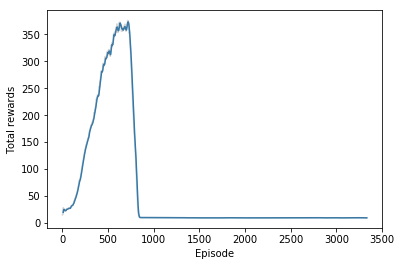

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

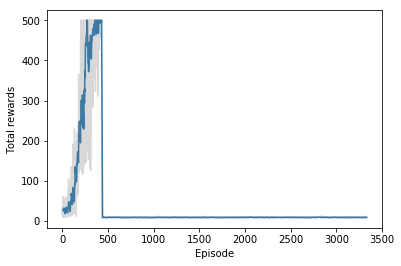

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

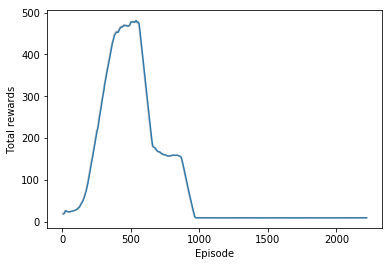

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

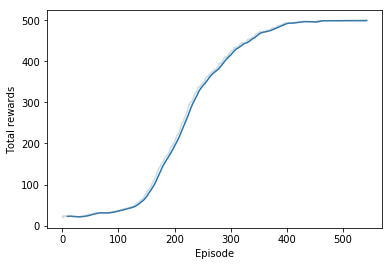

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

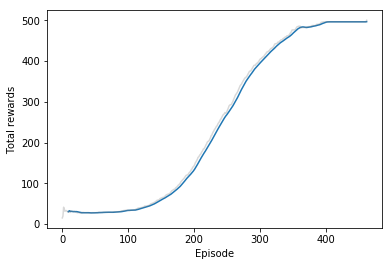

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

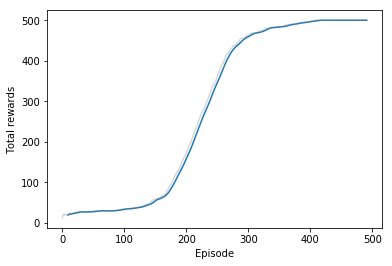

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

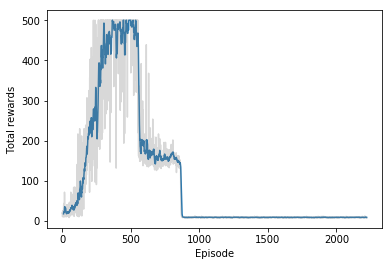

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

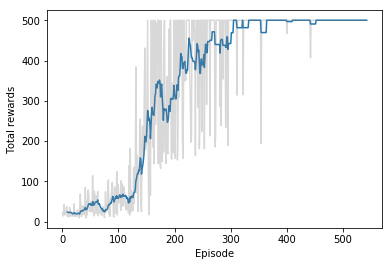

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

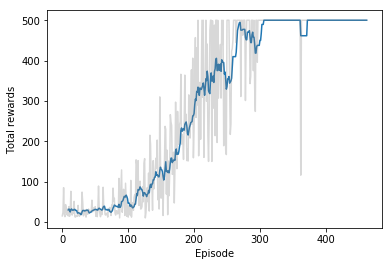

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

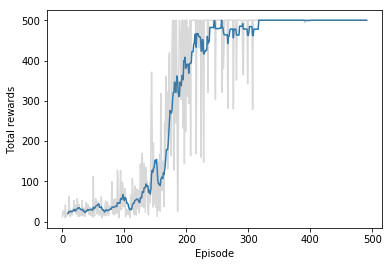

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.